## Artificial Intelligence & Machine Vision
## Image Multi-Class Classification using CNN

<h3>Objective for this Notebook</h3>    
<h5> Build an Image multi-class classifer using CNN</h5>    

<h2>Preparation</h2>

This code below sets up the necessary environment for building and training a deep learning model for image classification, specifically for predicting the make of vehicles. It includes tools for handling files, processing images, managing data, and implementing machine learning and deep learning models. The project is likely to involve tasks such as data preprocessing, model training, evaluation, and visualization.

In [6]:
# Import the libraries we need to use

# File and Directory Handling
import os
import time
import shutil
import pathlib
import itertools

# Image Processing
from PIL import Image

# Data Handling and Visualization
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

2024-01-24 10:40:44.127181: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Preprocessing

**Read data and store it in dataframe**

**Generate dataframe for the training dataset**

In [9]:
# Set the directory containing the training dataset
train_dir = 'cars_dataset/train'

# Initialize empty lists to store file paths and labels
filepaths = []
labels = []

# List subdirectories (folds) in the training directory
folds = os.listdir(train_dir)

# Iterate through each subdirectory (fold)
for fold in folds:
    # Create the full path for the current subdirectory
    foldpath = os.path.join(train_dir, fold)
    
    # List files in the current subdirectory
    filelist = os.listdir(foldpath)
    
    # Iterate through each file in the subdirectory
    for file in filelist:
        # Create the full path for the current file
        fpath = os.path.join(foldpath, file)
        
        # Append the file path to the 'filepaths' list
        filepaths.append(fpath)
        
        # Append the label (fold name) to the 'labels' list
        labels.append(fold)

# Create two pandas Series from the lists: one for file paths and one for labels
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')

# Concatenate the two Series into a DataFrame
train_df = pd.concat([Fseries, Lseries], axis=1)

# View the dataframe
train_df

,filepaths,labels
0,cars_dataset/train/Tata Safari/63.jpg,Tata Safari
1,cars_dataset/train/Tata Safari/189.jpg,Tata Safari
2,cars_dataset/train/Tata Safari/77.jpg,Tata Safari
3,cars_dataset/train/Tata Safari/638.jpg,Tata Safari
4,cars_dataset/train/Tata Safari/162.jpg,Tata Safari
...,...,...
3348,cars_dataset/train/Mahindra Scorpio/386.jpg,Mahindra Scorpio
3349,cars_dataset/train/Mahindra Scorpio/91.jpg,Mahindra Scorpio
3350,cars_dataset/train/Mahindra Scorpio/46.jpg,Mahindra Scorpio
3351,cars_dataset/train/Mahindra Scorpio/190.jpg,Mahindra Scorpio


**Generate dataframe for the testing dataset**

In [13]:
# Set the directory containing the test dataset
test_dir = 'cars_dataset/test'

# Initialize empty lists to store file paths and labels
filepaths = []
labels = []

# List subdirectories (folds) in the test directory
folds = os.listdir(test_dir)

# Iterate through each subdirectory (fold)
for fold in folds:
    # Create the full path for the current subdirectory
    foldpath = os.path.join(test_dir, fold)
    
    # List files in the current subdirectory
    filelist = os.listdir(foldpath)
    
    # Iterate through each file in the subdirectory
    for file in filelist:
        # Create the full path for the current file
        fpath = os.path.join(foldpath, file)
        
        # Append the file path to the 'filepaths' list
        filepaths.append(fpath)
        
        # Append the label (fold name) to the 'labels' list
        labels.append(fold)

# Create two pandas Series from the lists: one for file paths and one for labels
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')

# Concatenate the two Series into a DataFrame
test_df = pd.concat([Fseries, Lseries], axis=1)

# View the dataframe
test_df

,filepaths,labels
0,cars_dataset/test/Tata Safari/599.jpg,Tata Safari
1,cars_dataset/test/Tata Safari/214.jpg,Tata Safari
2,cars_dataset/test/Tata Safari/200.jpg,Tata Safari
3,cars_dataset/test/Tata Safari/229.jpg,Tata Safari
4,cars_dataset/test/Tata Safari/407.jpg,Tata Safari
...,...,...
808,cars_dataset/test/Mahindra Scorpio/379.jpg,Mahindra Scorpio
809,cars_dataset/test/Mahindra Scorpio/345.jpg,Mahindra Scorpio
810,cars_dataset/test/Mahindra Scorpio/85.jpg,Mahindra Scorpio
811,cars_dataset/test/Mahindra Scorpio/153.jpg,Mahindra Scorpio


**Split dataframe into validation and test set**

This code essentially splits the testing dataset into a validation set (valid_df) and a test set (test_df). The validation set will contain 60% of the original testing data, and the remaining 40% will be retained in the test set. 

In [14]:
# valid and test dataframe
valid_df, test_df = train_test_split(test_df,  train_size= 0.6, shuffle= True, random_state= 123)

**Create image data generator**

This code segment sets up image data generators using Keras' ImageDataGenerator class to load and preprocess images for training, validation, and testing. It's a crucial step when working with deep learning models, especially convolutional neural networks (CNNs), as it helps efficiently feed images into the model during training

In [15]:
# Set parameters for image preprocessing
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Create ImageDataGenerator instances for training and testing
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

# Create generators for training, validation, and testing datasets
train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 3352 validated image filenames belonging to 7 classes.
Found 487 validated image filenames belonging to 7 classes.
Found 326 validated image filenames belonging to 7 classes.


**Show sample from train data**

This code segment is used to visualize a batch of images along with their corresponding labels from the training data generator. It employs Matplotlib for creating a grid of images with their class names.

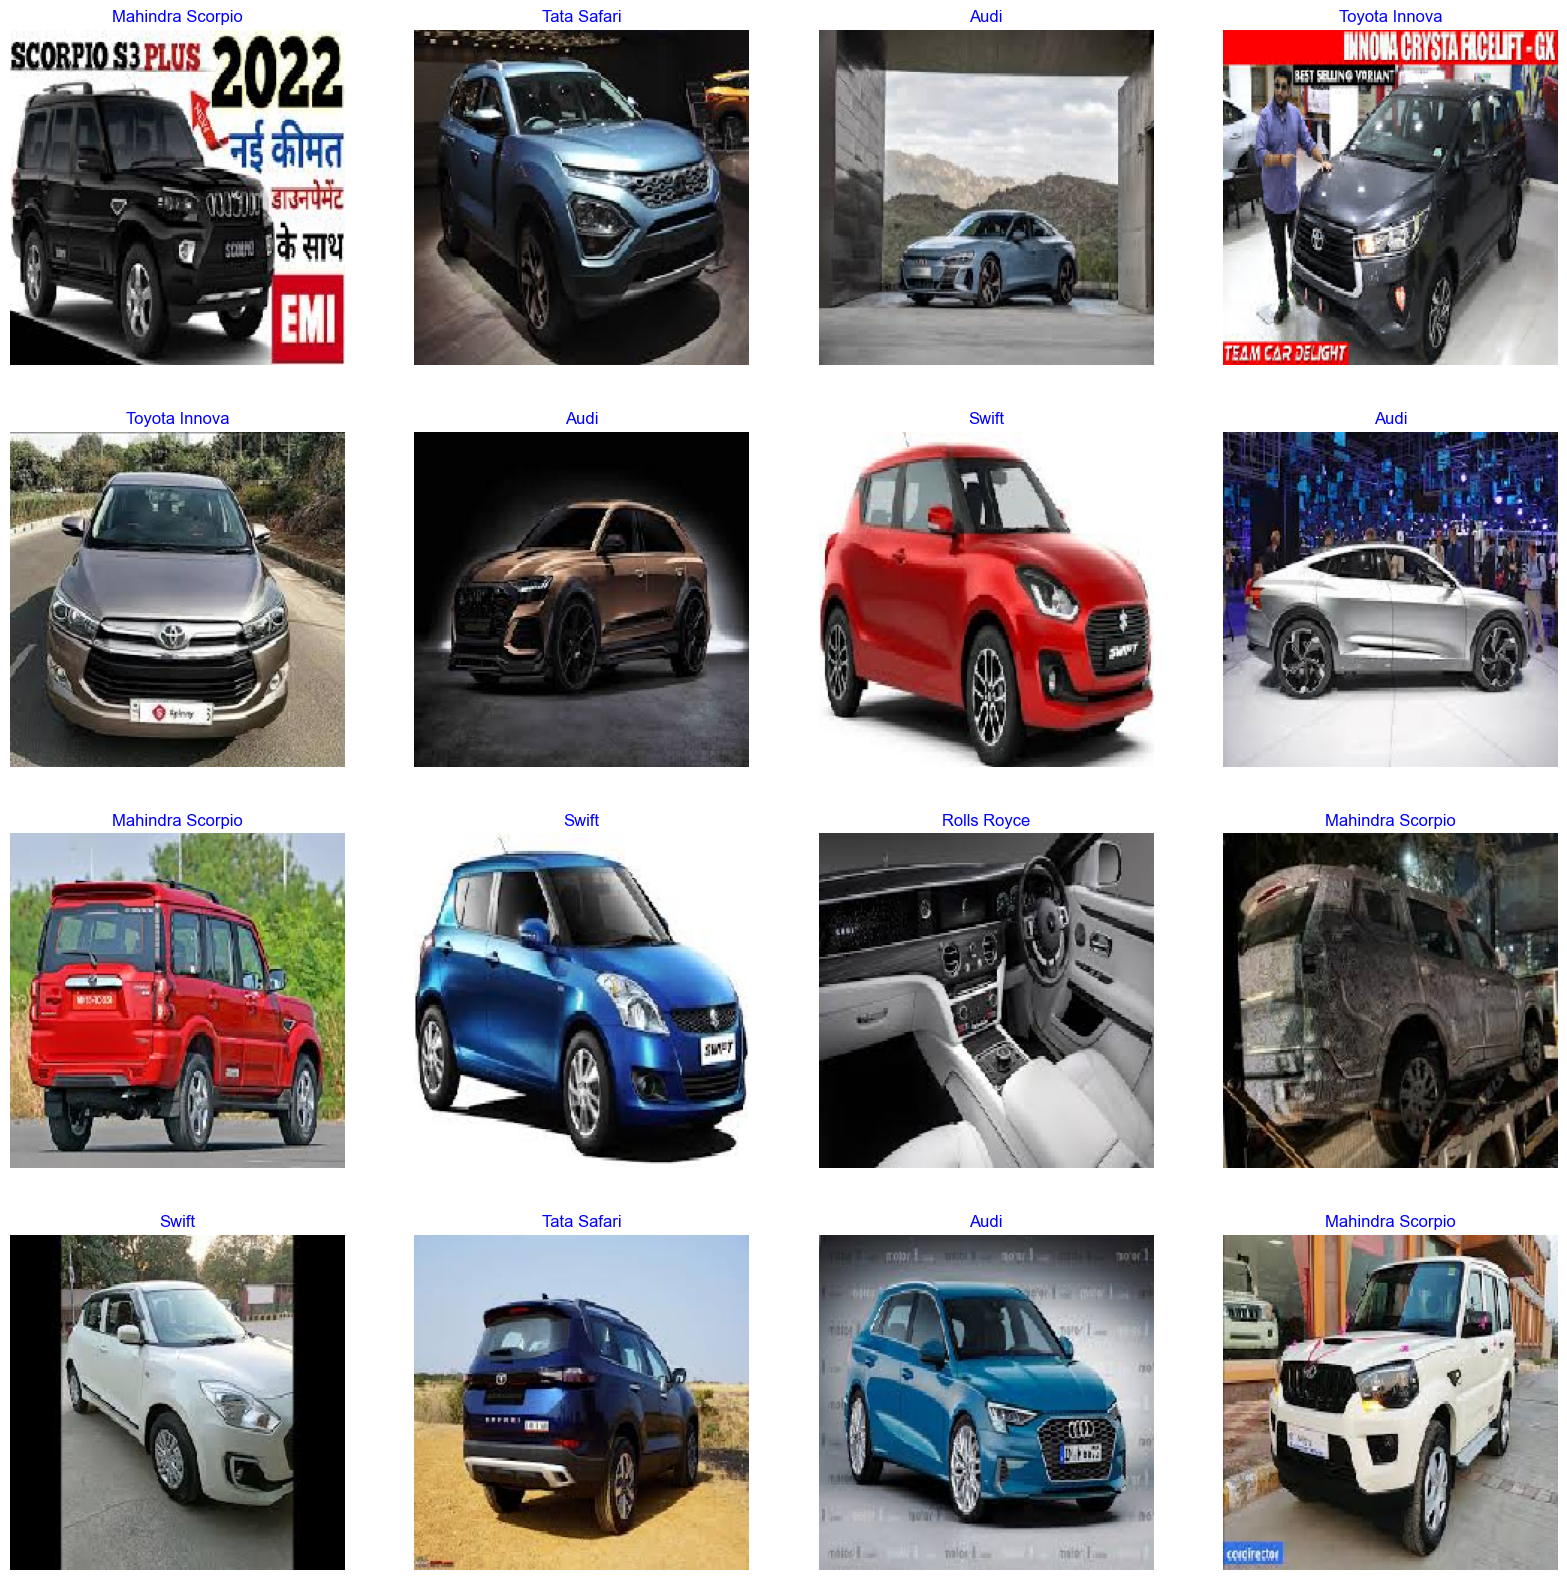

In [16]:
# Get class indices from the training data generator
g_dict = train_gen.class_indices

# Extract class names from the dictionary's keys (classes)
classes = list(g_dict.keys())

# Get a batch of samples from the training data generator
images, labels = next(train_gen)

# Plot the images along with their class names
plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    
    # Scale image data to the range (0 - 255)
    image = images[i] / 255
    plt.imshow(image)
    
    # Get the index of the maximum value in the labels (one-hot encoded)
    index = np.argmax(labels[i])
    
    # Retrieve the class name corresponding to the index
    class_name = classes[index]
    
    # Set title with class name in blue color
    plt.title(class_name, color='blue', fontsize=12)
    
    # Turn off axis labels
    plt.axis('off')

# Show the plot
plt.show()

# Create Model Structure

This code segment is responsible for creating a deep learning model for image classification using transfer learning. The model is built upon the EfficientNetB0 architecture, and it is customized with additional layers to suit the specific classification task

In [17]:
# Set image size and channels
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Determine the number of classes in the dense layer
class_count = len(list(train_gen.class_indices.keys()))

# Create a pre-trained model (EfficientNetB0 in this case)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False,  # Exclude the top (fully connected) layer
    weights="imagenet",  # Use pre-trained weights from ImageNet
    input_shape=img_shape,  # Input shape of the images
    pooling='max'  # Global max pooling at the end of the base model
)

# Build the complete model by adding custom layers on top of the pre-trained base
model = Sequential([
    base_model,  # EfficientNetB0 as the base
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),  # Batch normalization
    Dense(256,  # Dense layer with 256 units
          kernel_regularizer=regularizers.l2(l=0.016),  # L2 regularization for the kernel
          activity_regularizer=regularizers.l1(0.006),  # L1 regularization for the activity
          bias_regularizer=regularizers.l1(0.006),  # L1 regularization for the bias
          activation='relu'),  # ReLU activation function
    Dropout(rate=0.45, seed=123),  # Dropout layer with a dropout rate of 0.45
    Dense(class_count, activation='softmax')  # Output layer with softmax activation
])

# Compile the model with Adamax optimizer, categorical crossentropy loss, and accuracy metric
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 4384426 (16.73 MB)
Trainable params: 43398

**Train model**

This code segment is responsible for training the previously defined deep learning model using the provided training and validation data generators. The training process involves iterating through the dataset for a specified number of epochs, updating the model's weights based on the computed gradients, and monitoring the performance on the validation set.

In [23]:
# Set batch size for training
batch_size = 20

# Set the number of epochs for training
epochs = 3

# Train the model using the fit method
history = model.fit(
    x=train_gen,  # Training data generator
    epochs=epochs,  # Number of training epochs
    verbose=1,  # Verbosity mode (1 for progress bar, 0 for silent)
    validation_data=valid_gen,  # Validation data generator
    validation_steps=None,  # Number of validation steps per epoch (automatically determined)
    shuffle=False  # Disable shuffling of training data during training
)


Epoch 1/3
210/210 [==============================] - 532s 3s/step - loss: 1.0474 - accuracy: 0.9940 - val_loss: 0.8571 - val_accuracy: 0.9795
Epoch 2/3
210/210 [==============================] - 530s 3s/step - loss: 0.7116 - accuracy: 0.9949 - val_loss: 0.5852 - val_accuracy: 0.9856
Epoch 3/3
210/210 [==============================] - 549s 3s/step - loss: 0.5059 - accuracy: 0.9961 - val_loss: 0.4269 - val_accuracy: 0.9918


**Display model performance**

This code is responsible for visualizing the training and validation performance of the deep learning model over epochs. It uses Matplotlib to create two subplots: one for loss metrics and another for accuracy metrics.

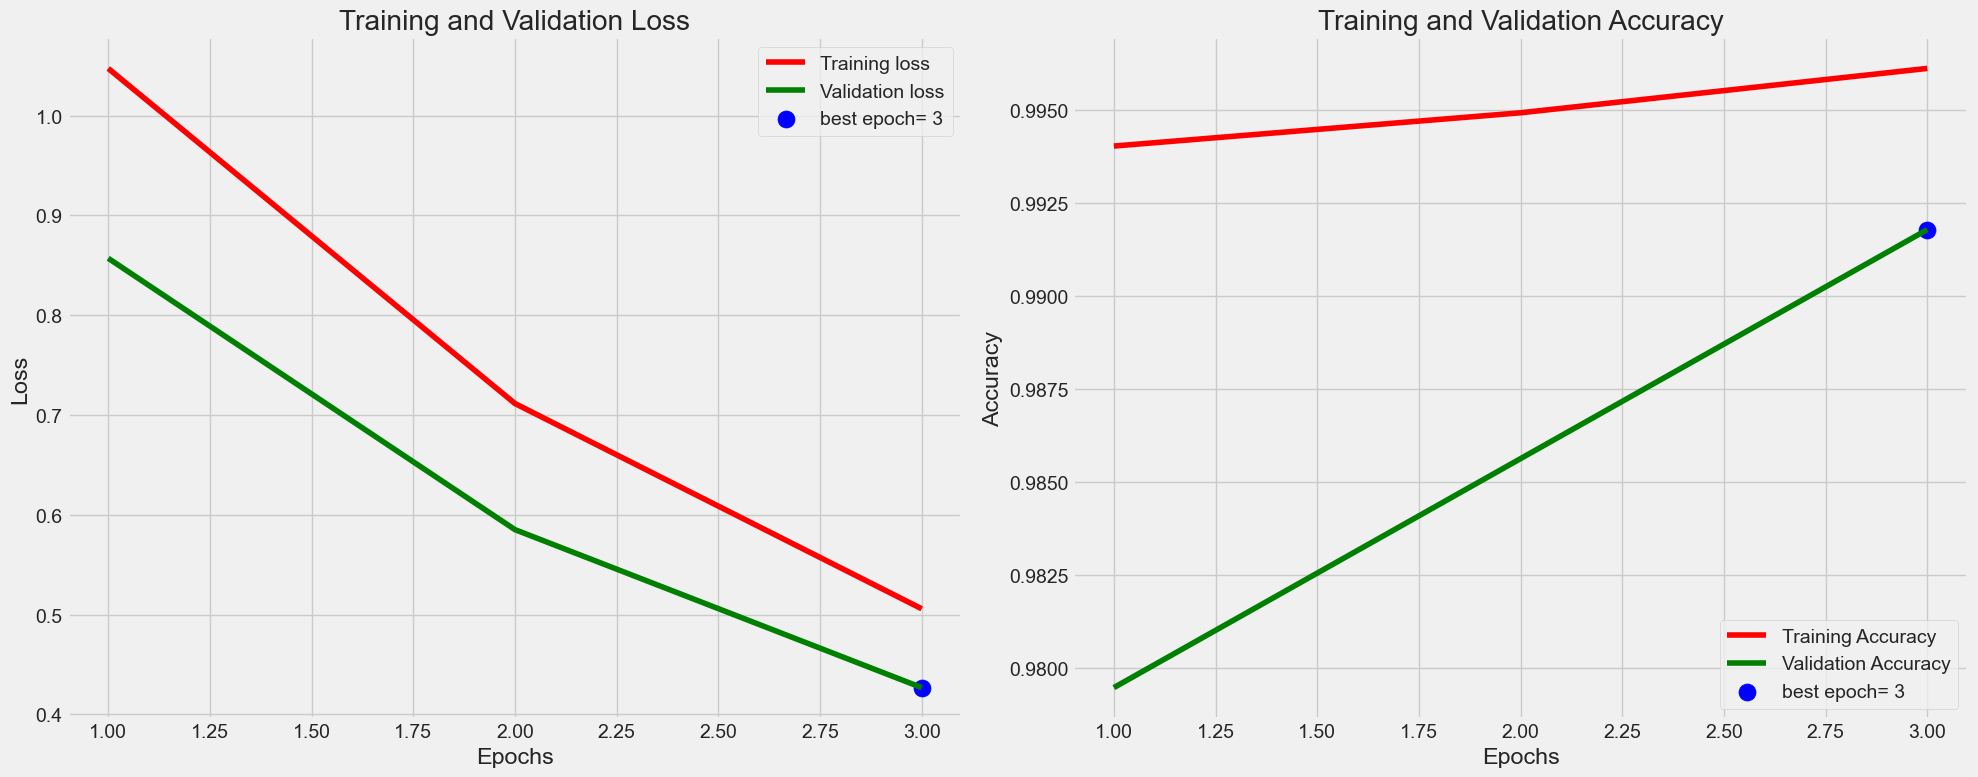

In [24]:
# Extract relevant metrics from the training history
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Find the epoch with the lowest validation loss
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

# Find the epoch with the highest validation accuracy
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

# Create a list of epoch numbers
Epochs = [i + 1 for i in range(len(tr_acc))]

# Define labels for the points on the plot
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

# Subplot for loss metrics
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot for accuracy metrics
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Adjust layout for better presentation
plt.tight_layout()

# Show the plot
plt.show()


# Evaluate the model

This code is used to evaluate the performance of the trained deep learning model on the training, validation, and test datasets. It calculates and prints the loss and accuracy scores for each dataset.

In [25]:
# Determine the length of the test dataset
ts_length = len(test_df)

# Determine an appropriate batch size for testing
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))

# Calculate the number of steps for testing
test_steps = ts_length // test_batch_size

# Evaluate the model on the training dataset
train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)

# Evaluate the model on the validation dataset
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)

# Evaluate the model on the test dataset
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

# Print the evaluation results
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


163/163 [==============================] - 10s 61ms/step - loss: 0.4475 - accuracy: 0.9816
Train Loss:  0.3936200737953186
Train Accuracy:  1.0
--------------------
Validation Loss:  0.42688387632369995
Validation Accuracy:  0.9917864203453064
--------------------
Test Loss:  0.44753193855285645
Test Accuracy:  0.9815950989723206


**Get Predictions**

This code segment is used to obtain predictions from the trained deep learning model for the test dataset. It uses the predict_generator method to generate predictions for the test samples, and then np.argmax is applied along the specified axis to determine the predicted class labels.

In [26]:
# Generate predictions for the test dataset using the trained model
preds = model.predict_generator(test_gen)

# Extract the predicted class labels by finding the indices with the maximum probability
y_pred = np.argmax(preds, axis=1)


**Confusion Matrix and Classification Report**

This code generates and displays a confusion matrix based on the true labels and predicted labels of the test dataset. The confusion matrix is a useful tool for visualizing the performance of a classification model by showing the counts of true positive, true negative, false positive, and false negative predictions. 

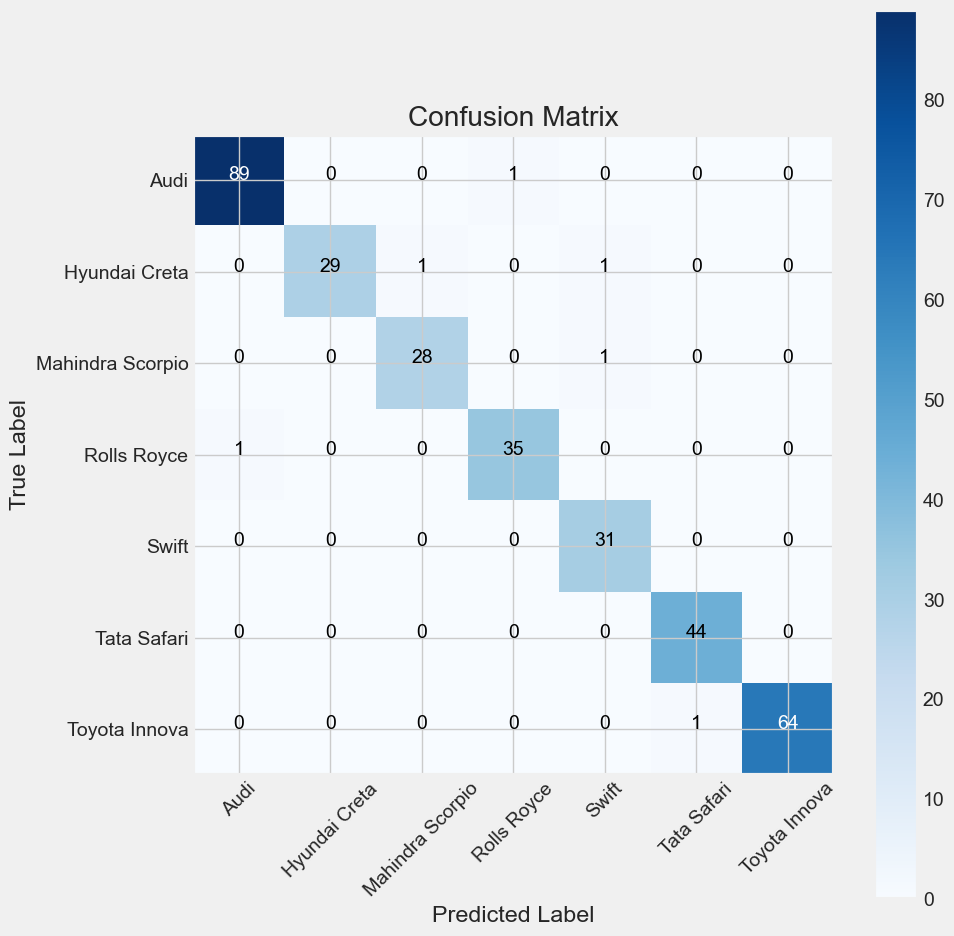

In [27]:
# Get the class indices from the test data generator
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Calculate the confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Set ticks and labels for classes
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations to each cell in the matrix
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

# Adjust layout for better presentation
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Show the plot
plt.show()


The classification_report function is used to generate a comprehensive report that includes various classification metrics such as precision, recall, F1-score, and support for each class. This report provides a detailed analysis of the model's performance on the test dataset, offering insights into how well it performs for each class

In [28]:
# Generate and print the classification report
print(classification_report(test_gen.classes, y_pred, target_names=classes))


                  precision    recall  f1-score   support

            Audi       0.99      0.99      0.99        90
   Hyundai Creta       1.00      0.94      0.97        31
Mahindra Scorpio       0.97      0.97      0.97        29
     Rolls Royce       0.97      0.97      0.97        36
           Swift       0.94      1.00      0.97        31
     Tata Safari       0.98      1.00      0.99        44
   Toyota Innova       1.00      0.98      0.99        65

        accuracy                           0.98       326
       macro avg       0.98      0.98      0.98       326
    weighted avg       0.98      0.98      0.98       326



**Save the model**

The code snippet model.save('model.h5') is used to save the entire trained deep learning model to a file in the Hierarchical Data Format version 5 (HDF5) format. This allows you to store the model's architecture, weights, and other configuration details for future use or deployment.

In [29]:
# Save the entire model to a file named 'model.h5'
model.save('model.h5')


# Prediction using loaded model

This code is used to load a saved Keras model from a file and then compile it with a specified optimizer, loss function, and metrics.

In [30]:
# Load the saved model without compiling
loaded_model = tf.keras.models.load_model('model.h5', compile=False)

# Compile the loaded model with a specific optimizer, loss, and metrics
loaded_model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


**Test if the model is working**

This code snippet demonstrates how to use a loaded and compiled deep learning model to make predictions on a single image. It also provides a visual representation of the image along with the predicted make and confidence score. The code is useful for understanding how well the model performs on individual examples and can be extended for batch predictions or integration into larger applications.

1/1 [==============================] - 1s 1s/step


(-0.5, 223.5, 223.5, -0.5)

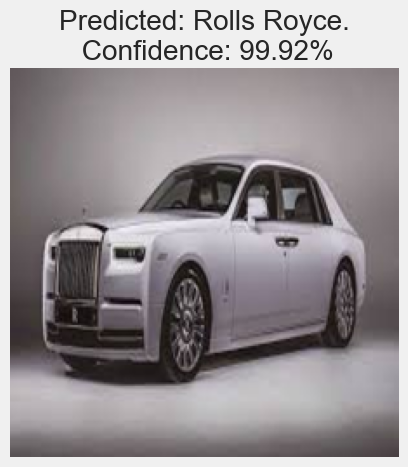

In [31]:
# Specify the path to the test image
image_path = 'cars_dataset/test/Rolls Royce/110.jpg'

# Open the image using the Python Imaging Library (PIL)
image = Image.open(image_path)

# Preprocess the image
# Resize the image to the expected input size of the model (224x224 pixels)
img = image.resize((224, 224))

# Convert the image to a NumPy array
img_array = tf.keras.preprocessing.image.img_to_array(img)

# Add an extra dimension to the array to match the expected input shape (batch size of 1)
img_array = tf.expand_dims(img_array, 0)

# Make predictions using the pre-trained and compiled model
predictions = loaded_model.predict(img_array)

# Retrieve class labels
class_labels = classes

# Calculate softmax scores to get probabilities for each class
score = tf.nn.softmax(predictions[0])

# Identify the predicted class label
make = class_labels[tf.argmax(score)]

# Get the confidence score
confidence = round(100 * (np.max(predictions[0])), 2)

# Display the original image with prediction information
plt.title(f"Predicted: {make}.\n Confidence: {confidence}%")
plt.imshow(img)
plt.axis("off")
